<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio de Gestión de Outliers

AutoRenew, la empresa líder en la venta de coches de segunda mano, sigue adelante con el desarrollo del modelo predictivo que ayudará a estimar el precio de los vehículos usados. Este modelo es clave para mejorar las estrategias de ventas, marketing y optimización del inventario de la empresa. Ya has realizado un análisis exploratorio inicial y gestionado los valores nulos en el conjunto de datos. Ahora, es el momento de abordar otro aspecto crucial del preprocesamiento: la **gestión de outliers**.

En este laboratorio, te enfocarás en identificar y gestionar los outliers (valores atípicos) presentes en el conjunto de datos. Los outliers pueden distorsionar los resultados de un análisis y afectar negativamente el rendimiento de los modelos predictivos, por lo que es fundamental tratarlos adecuadamente antes de proceder con las siguientes fases del proyecto.


**Instrucciones:**

1. **Identificación de Outliers:** Explora las columnas clave del conjunto de datos (como `price`, `powerCV`, `kilometer`, etc.) para identificar posibles outliers. Utiliza gráficos como diagramas de caja (boxplots) y análisis estadísticos para detectar valores que se desvíen significativamente del resto de los datos.

2. **Análisis de Outliers:** Una vez identificados, analiza los outliers para determinar si son errores de datos, valores extremos válidos o resultados de condiciones específicas que deben ser tenidos en cuenta. Considera el contexto de cada columna al evaluar la relevancia de estos valores atípicos.

3. **Gestión de Outliers:** Decide la estrategia más adecuada para manejar los outliers. Esto podría incluir la eliminación de los outliers, la transformación de los datos, o la aplicación de técnicas de imputación. Justifica tu elección basándote en cómo los outliers podrían afectar el modelo predictivo.

**Nota:** Recuerda que este laboratorio es parte de una serie de actividades en las que utilizarás el mismo conjunto de datos a lo largo de la semana. Documenta cuidadosamente los pasos que sigas para que puedas referirte a ellos en las próximas etapas del proyecto.


In [108]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px



# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon

# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product, combinations

# Gestionar warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [109]:
from src import soporte_outliers as so

In [110]:
from src import soporte_preprocesamiento as sp

In [111]:
df = pd.read_csv("datos/robust.csv",index_col=0)

In [112]:
df.head()

,price,powerCV_robust,kilometer_robust
0,480.0,-0.374913,0.0
1,18300.0,1.128683,-1.0
2,9800.0,0.746735,-1.0
3,1500.0,-0.531319,0.0
4,3600.0,-0.619461,-2.4


Los datos de las columnas de powerCV_robust y kilometer_robust están escalados con RobustScaler

### Identificación de outliers

Para comenzar la identificación de outliers, sacamos boxplot de las tres variables para ver sus distribuciones 

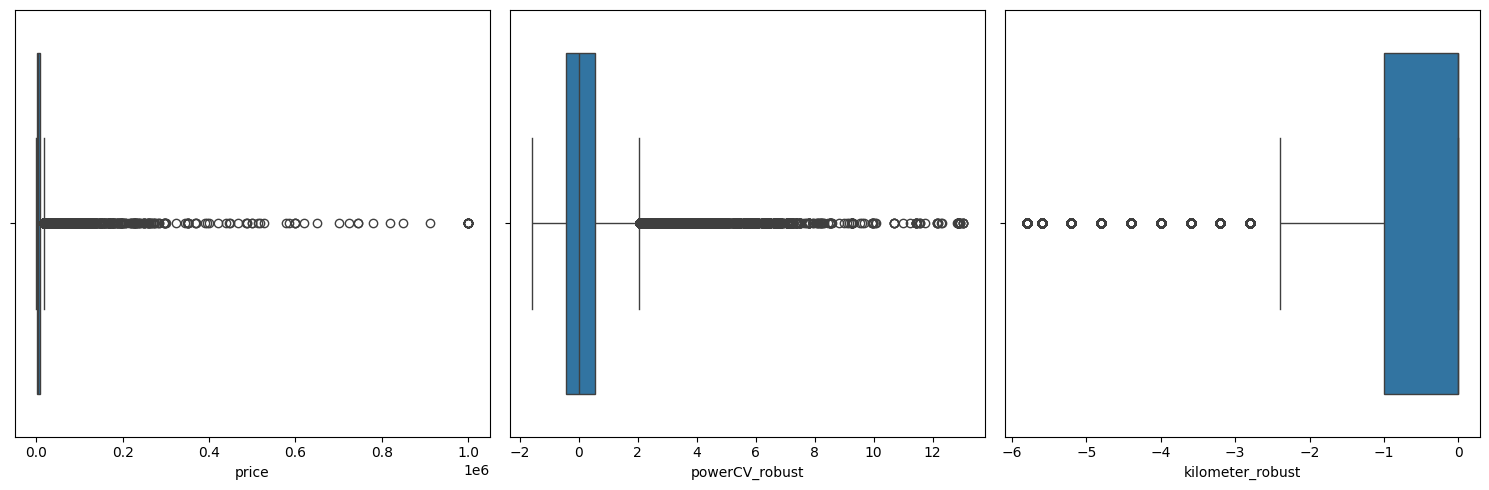

In [113]:
fig , axes = plt.subplots(nrows=1 , ncols=3, figsize = (15, 5) )

sns.boxplot(x="price", data=df, ax=axes[0])
sns.boxplot(x="powerCV_robust", data=df, ax=axes[1])
sns.boxplot(x="kilometer_robust", data=df, ax=axes[2])

plt.tight_layout()


Las gráficas nos sirven para visualizar los outliers pero no nos permiten situar con precisión ni la cantidad ni la posición de los mismos

Vamos a extraer analiticamente los outliers univariados más información sobr los outliers

In [114]:
so.describe_outliers(df)

,columna,n_outliers,limite_inf,limite_sup,%_outliers
2,kilometer_robust,64221,-2.500000,1.500000,17.29
0,price,28089,-7825.000000,16375.000000,7.56
1,powerCV_robust,12494,-1.944238,2.055762,3.36


Con este metodo hemos identificado outliers con el metodo IQR. El método z-score no procede en este caso pues nuestros datos tienen una distribución alejada de la de la normal.

Pasamos a los outliers multivariados

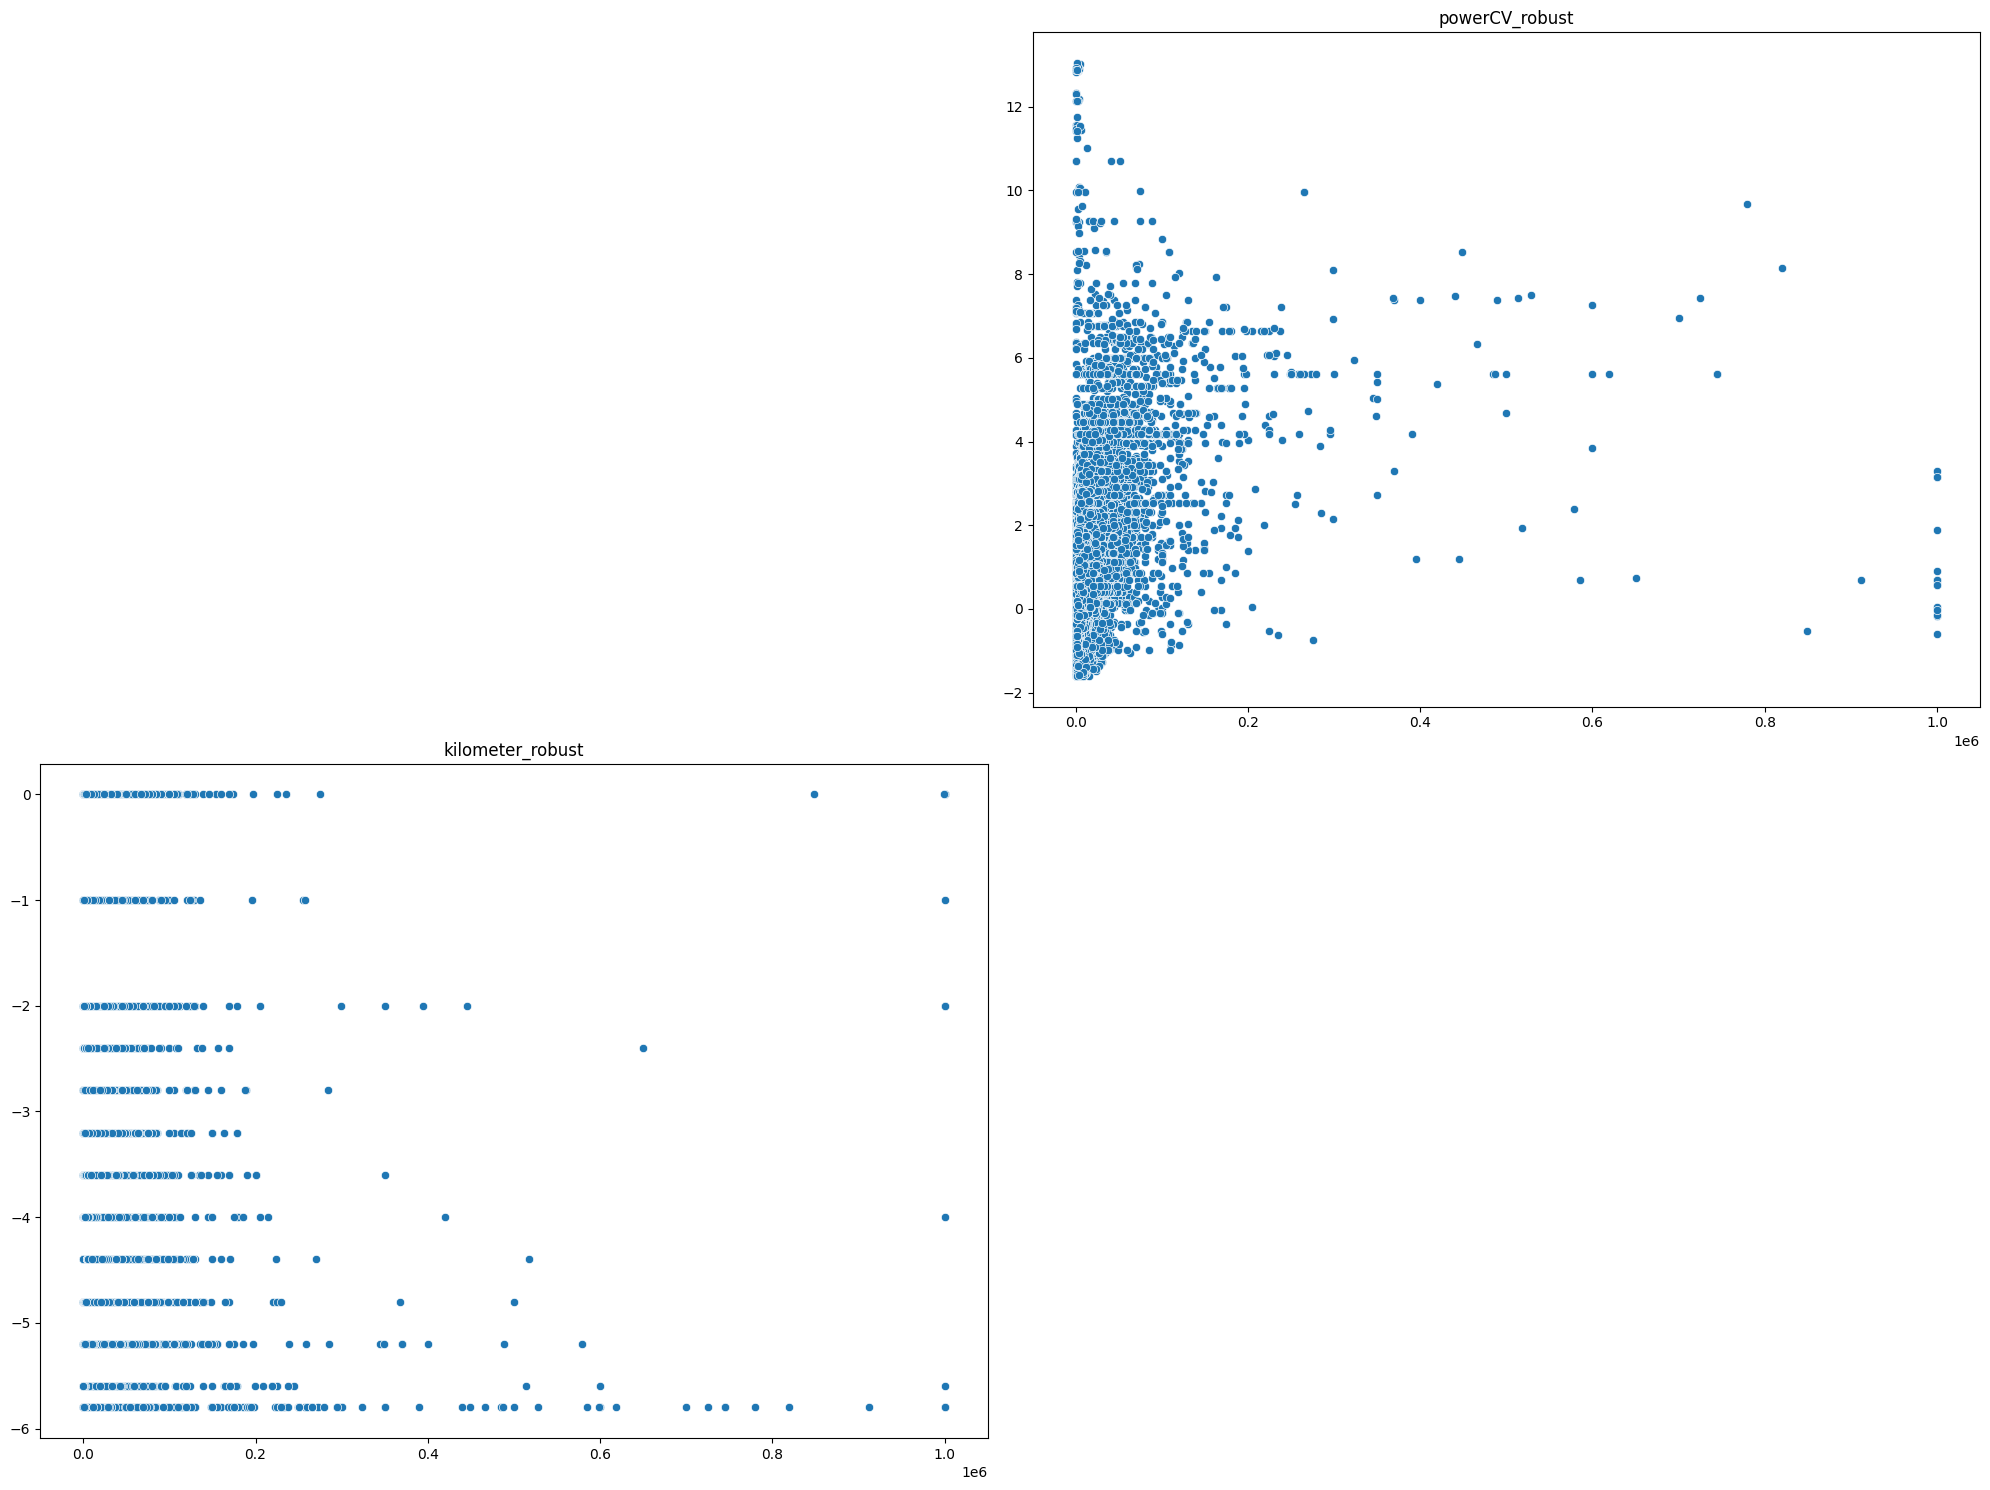

In [115]:
# instanciamos la clase de indentificación de Outliers Multivariados. En este caso usamos las funciones definidas en los apuntes
gestion_multi= so.GestionOutliersMultivariados(df)

# llamamos al método que nos permite identificar los outliers
gestion_multi.visualizar_outliers_bivariados("price")

Los diagramas de dispersión visualizan muy bien los *outliers* pero no los identifican en el conjunto de datos

Vamos a usar el metodo LOF para detectar los outliers multivariados, parece el más adecuado dado que tenemos datos muy similares y muy variados

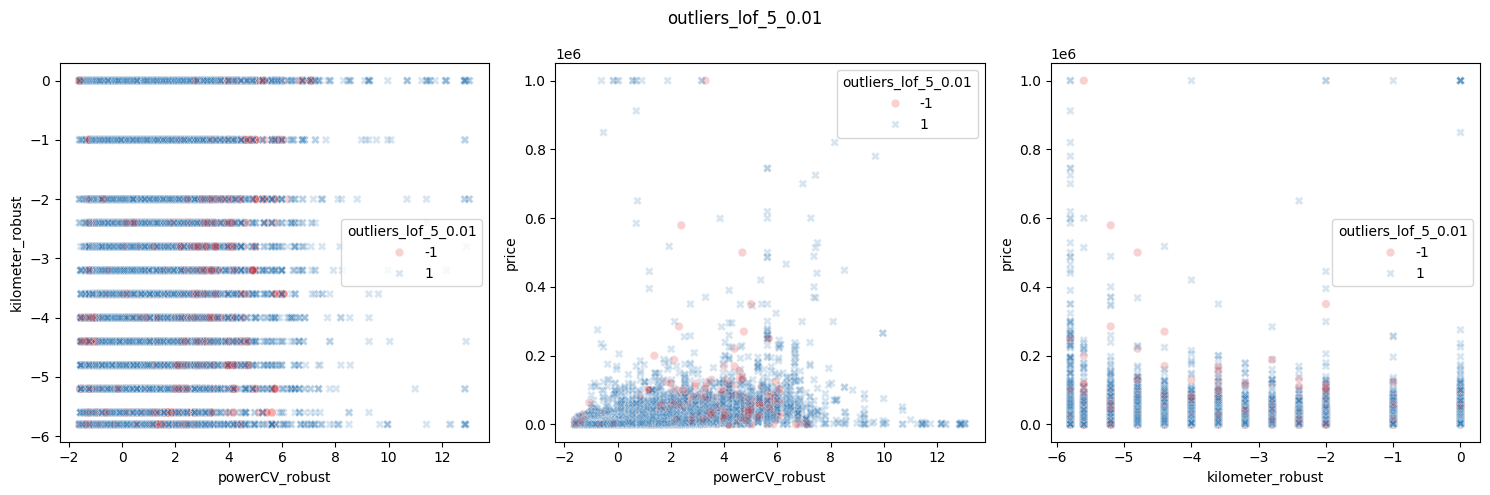

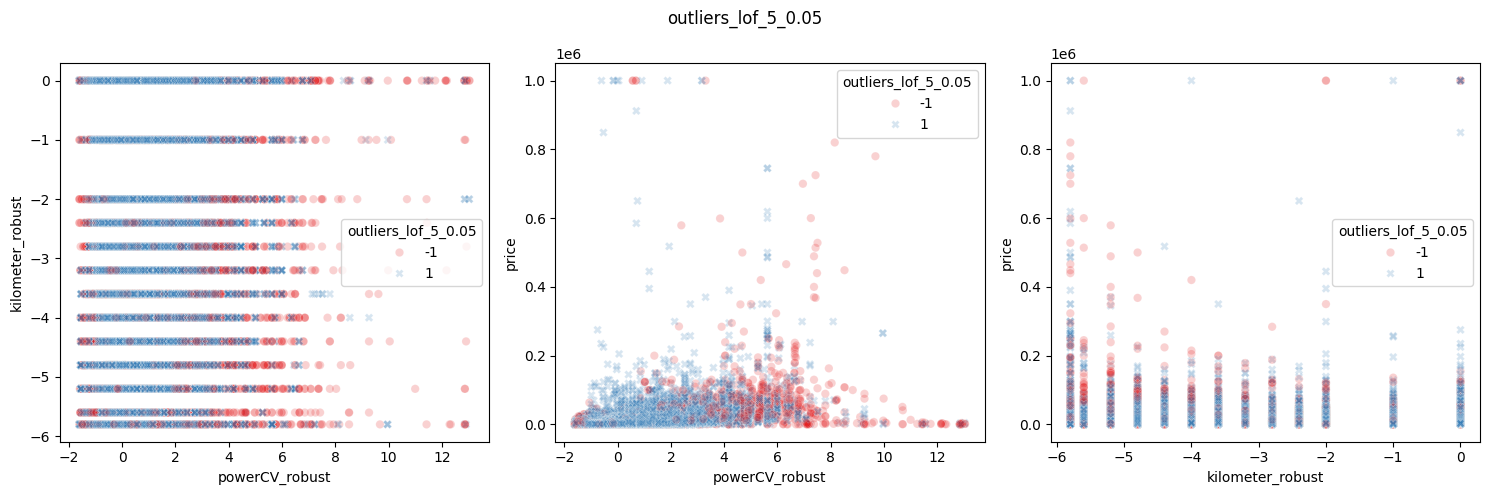

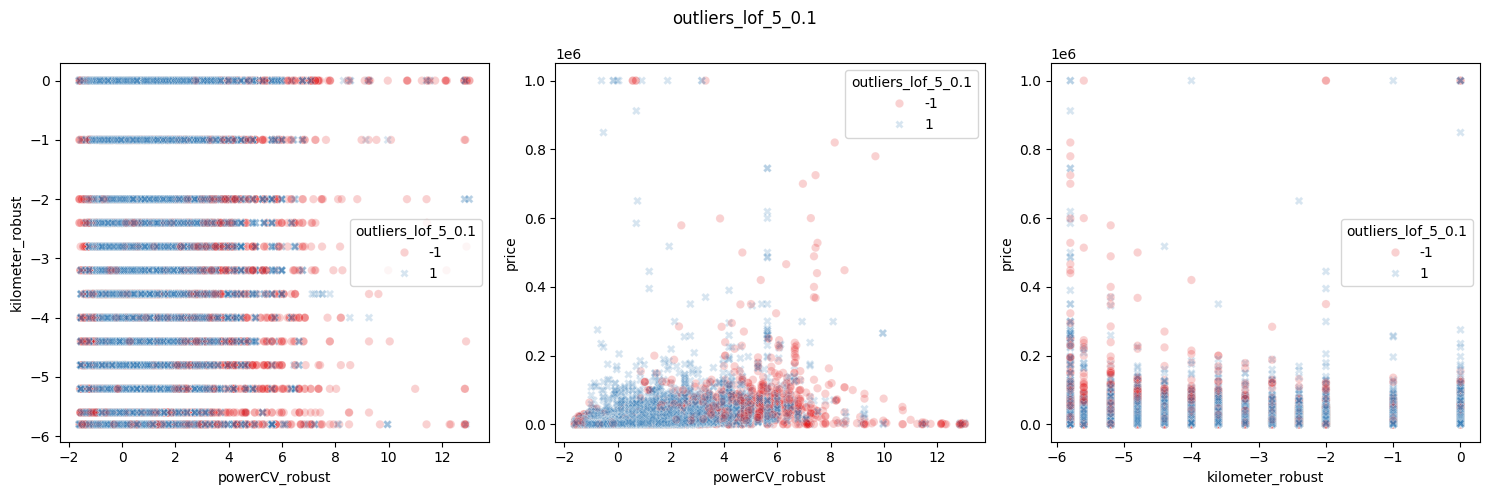

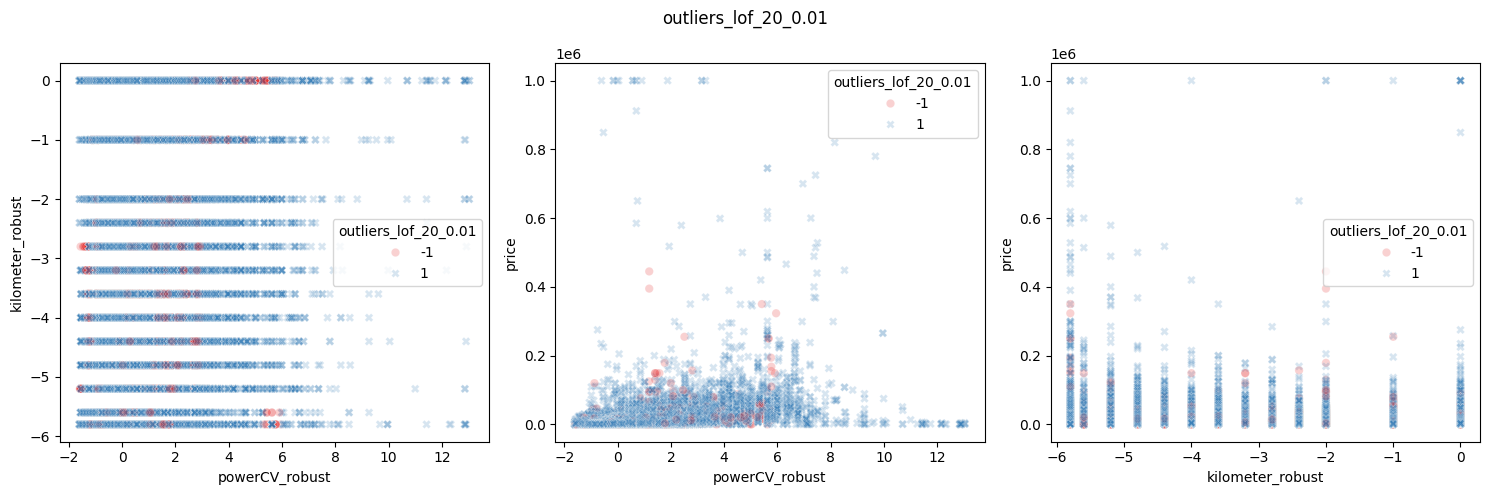

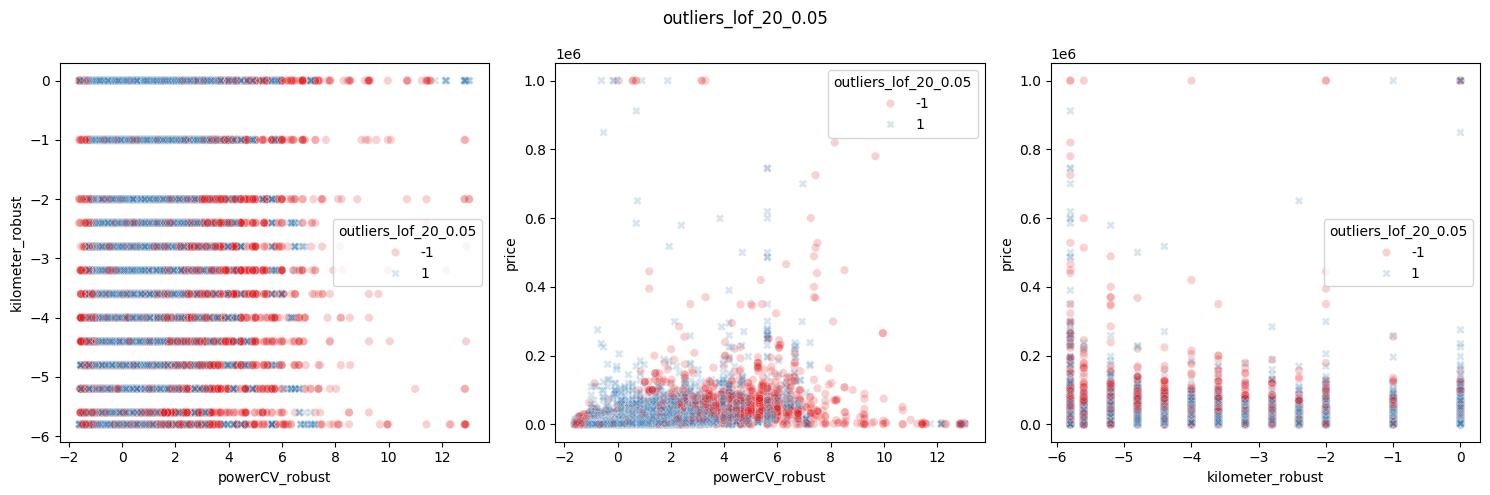

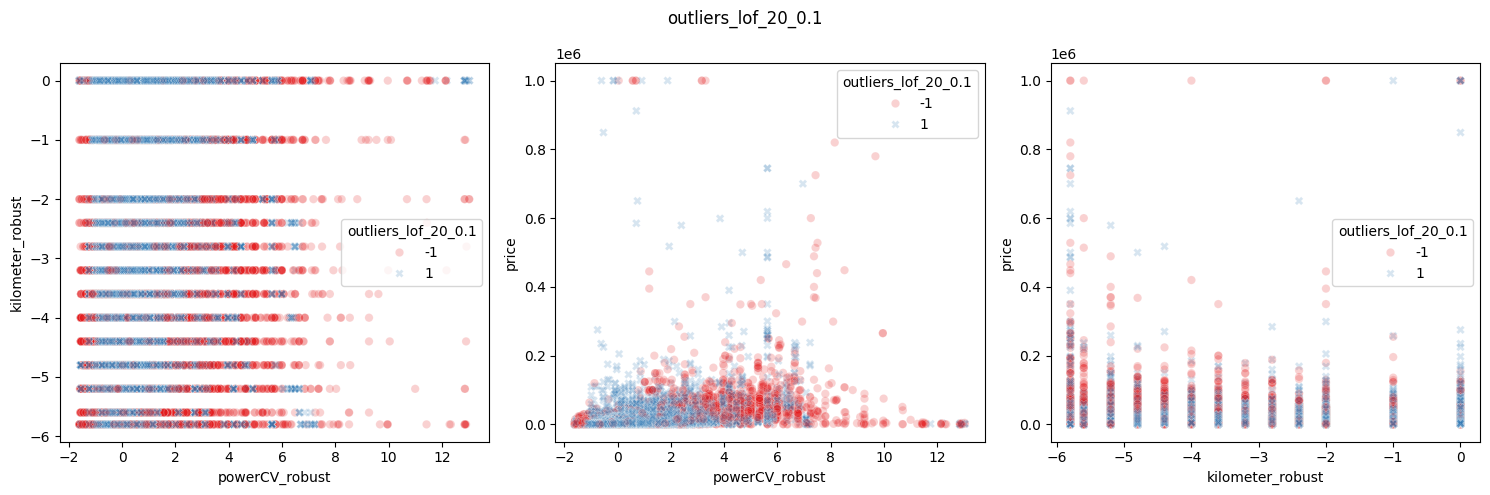

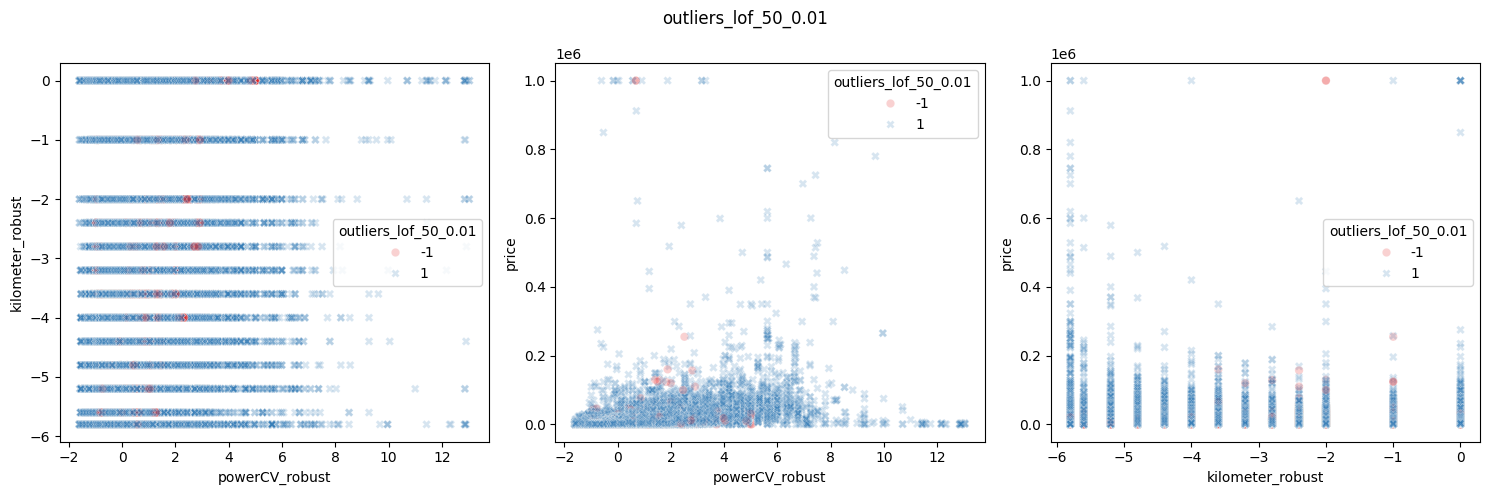

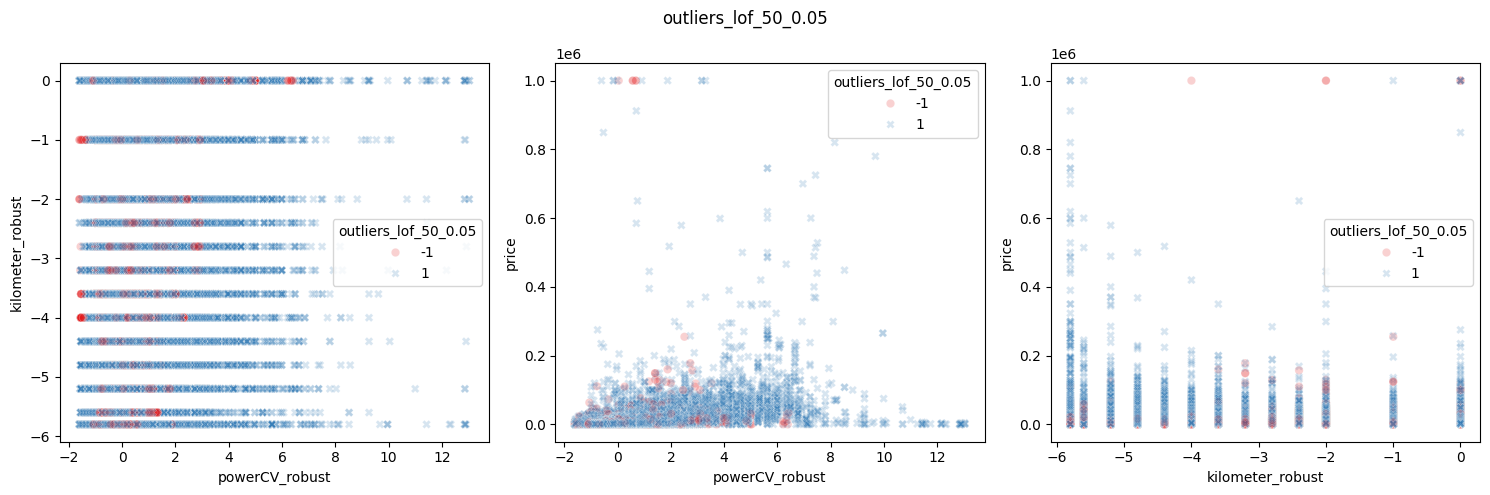

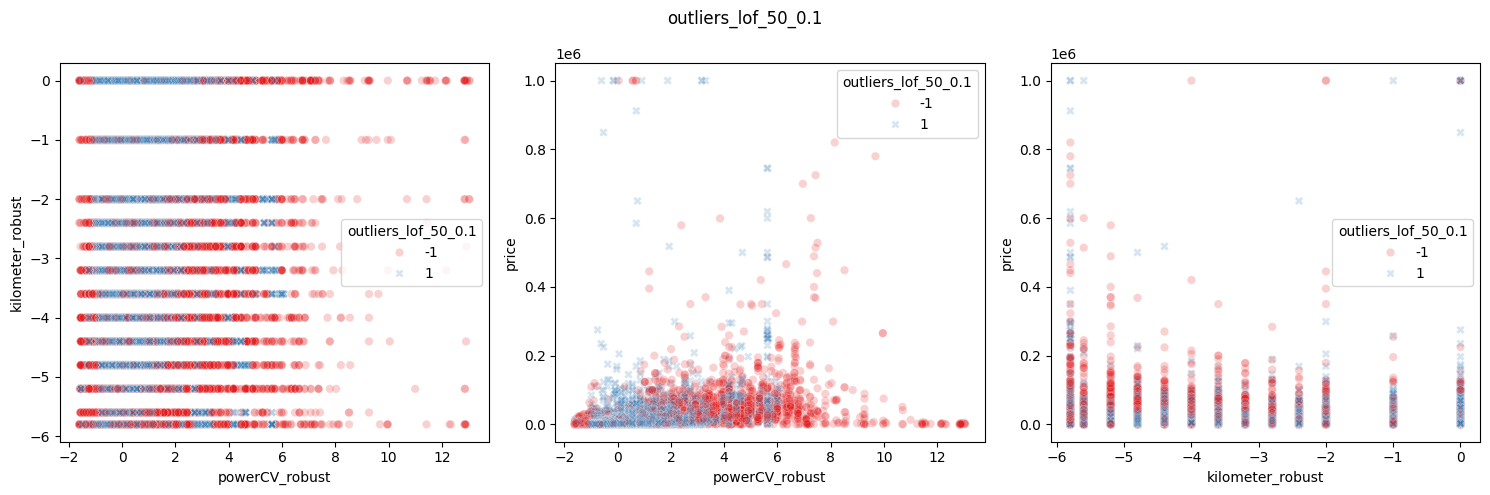

In [116]:
def gestion_nulos_lof(df, col_numericas, list_neighbors, lista_contaminacion):
    
    combinaciones = list(product(list_neighbors, lista_contaminacion))
    
    for neighbors, contaminacion in combinaciones:
        lof = LocalOutlierFactor(n_neighbors=neighbors, 
                                 contamination=contaminacion,
                                 n_jobs=-1)
        df[f"outliers_lof_{neighbors}_{contaminacion}"] = lof.fit_predict(df[col_numericas])

    return df

col_numericas=['powerCV_robust', 'kilometer_robust']
lista_vecinos=[5, 20, 50]
list_contaminacion = [0.01, 0.05, 0.1]

df_lof = df.copy()
df_lof = gestion_nulos_lof(df_lof, col_numericas, lista_vecinos, list_contaminacion)

combinaciones_variables = list(combinations(['powerCV_robust', 'kilometer_robust', 'price'], 2))
columnas_hue = df_lof.filter(like="outlier").columns

for col_hue in columnas_hue:
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
    axes = axes.flat

    for indice, tupla in enumerate(combinaciones_variables):
        sns.scatterplot(df_lof, x=tupla[0], y=tupla[1], ax=axes[indice], hue = col_hue, palette="Set1", style=col_hue, alpha=0.2)
        plt.suptitle(f"{col_hue}")
        plt.tight_layout()

In [117]:
df_lof.head()

,price,powerCV_robust,kilometer_robust,outliers_lof_5_0.01,outliers_lof_5_0.05,outliers_lof_5_0.1,outliers_lof_20_0.01,outliers_lof_20_0.05,outliers_lof_20_0.1,outliers_lof_50_0.01,outliers_lof_50_0.05,outliers_lof_50_0.1
0,480.0,-0.374913,0.0,1,1,1,1,1,1,1,1,1
1,18300.0,1.128683,-1.0,1,1,1,1,1,1,1,1,1
2,9800.0,0.746735,-1.0,1,1,1,1,1,1,1,1,1
3,1500.0,-0.531319,0.0,1,1,1,1,1,1,1,1,1
4,3600.0,-0.619461,-2.4,1,1,1,1,1,1,1,1,1


In [118]:
df_iterative = pd.read_csv("datos/iterative.csv", index_col=0)

In [119]:
df_iterative= df_iterative.drop(columns=['price', 'powerCV', 'kilometer', 'monthOfRegistration'])


In [120]:
df_outliers =  pd.concat([df_iterative, df_lof], axis=1)

In [121]:
# Filtramos el DataFrame eliminando las columnas categóricas
df_outliers = df_outliers.select_dtypes(exclude=['object'])

df_outliers.head()


,postalCode,price,powerCV_robust,kilometer_robust,outliers_lof_5_0.01,outliers_lof_5_0.05,outliers_lof_5_0.1,outliers_lof_20_0.01,outliers_lof_20_0.05,outliers_lof_20_0.1,outliers_lof_50_0.01,outliers_lof_50_0.05,outliers_lof_50_0.1
0,70435,480.0,-0.374913,0.0,1,1,1,1,1,1,1,1,1
1,66954,18300.0,1.128683,-1.0,1,1,1,1,1,1,1,1,1
2,90480,9800.0,0.746735,-1.0,1,1,1,1,1,1,1,1,1
3,91074,1500.0,-0.531319,0.0,1,1,1,1,1,1,1,1,1
4,60437,3600.0,-0.619461,-2.4,1,1,1,1,1,1,1,1,1


In [122]:
df_outliers.shape

(371528, 13)

Consideraremos outliers aquellas filas que contengan más de 60% de outliers, en este caso, tenemos 9 columnas de outliers, que serían 5/9.

In [123]:
cantidad = 5
df_filtrado = df_outliers[(df_outliers == -1).sum(axis=1) > cantidad]


In [124]:
df_filtrado.head()

,postalCode,price,powerCV_robust,kilometer_robust,outliers_lof_5_0.01,outliers_lof_5_0.05,outliers_lof_5_0.1,outliers_lof_20_0.01,outliers_lof_20_0.05,outliers_lof_20_0.1,outliers_lof_50_0.01,outliers_lof_50_0.05,outliers_lof_50_0.1
32,44145,245.0,-0.531043,0.0,1,-1,-1,1,-1,-1,1,-1,-1
96,29221,8390.0,0.811626,0.0,1,-1,-1,1,-1,-1,1,-1,-1
101,23568,4290.0,0.369673,0.0,1,-1,-1,1,-1,-1,1,-1,-1
104,88167,22999.0,2.773994,-4.0,-1,-1,-1,1,-1,-1,1,1,-1
162,34314,7500.0,1.187444,-5.8,-1,-1,-1,-1,-1,-1,1,1,-1


In [125]:
df_outliers.describe()


,postalCode,price,powerCV_robust,kilometer_robust,outliers_lof_5_0.01,outliers_lof_5_0.05,outliers_lof_5_0.1,outliers_lof_20_0.01,outliers_lof_20_0.05,outliers_lof_20_0.1,outliers_lof_50_0.01,outliers_lof_50_0.05,outliers_lof_50_0.1
count,371528.00000,371528.000000,371528.000000,371528.000000,371528.000000,371528.000000,371528.000000,371528.000000,371528.000000,371528.000000,371528.000000,371528.000000,371528.000000
mean,50820.66764,5923.847881,0.177561,-0.975252,0.980002,0.955540,0.955540,0.980034,0.900008,0.896735,0.980061,0.900126,0.827249
std,25799.08247,12053.036525,0.885072,1.604493,0.198990,0.294861,0.294861,0.198831,0.435875,0.442569,0.198698,0.435630,0.561837
min,1067.00000,1.000000,-1.603710,-5.800000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,30459.00000,1250.000000,-0.444238,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,49610.00000,3000.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,71546.00000,7300.000000,0.555762,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,99998.00000,999999.000000,13.042500,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [126]:
visualizador = sp.Visualizador(df_filtrado)

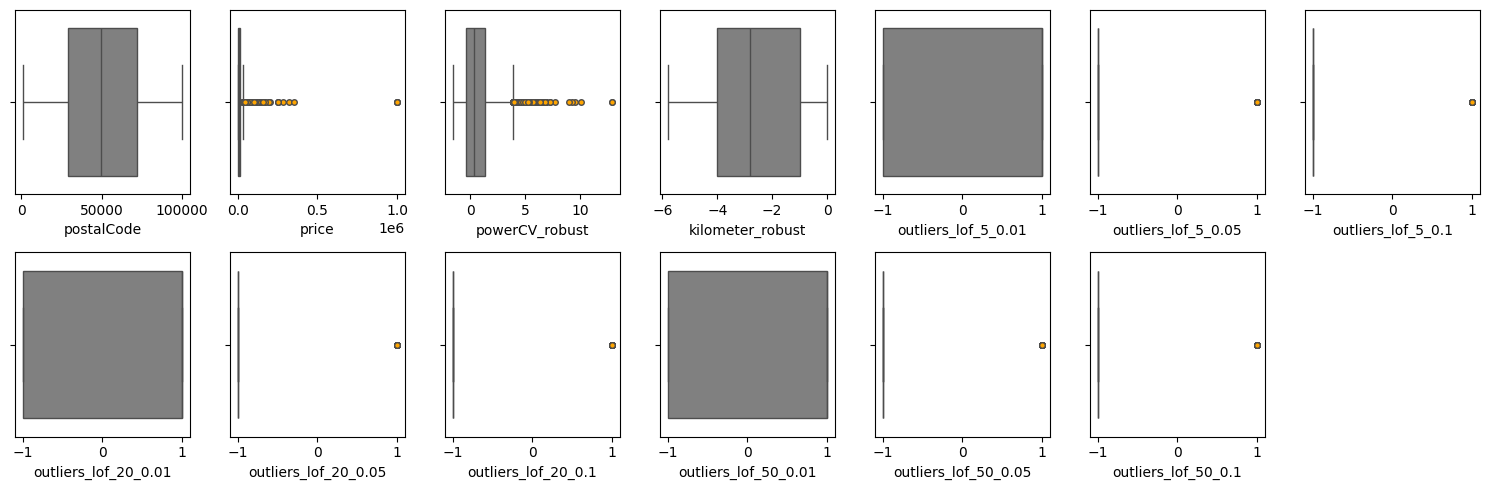

In [127]:
visualizador.deteccion_outliers()

In [128]:
df_filtrado.describe()

,postalCode,price,powerCV_robust,kilometer_robust,outliers_lof_5_0.01,outliers_lof_5_0.05,outliers_lof_5_0.1,outliers_lof_20_0.01,outliers_lof_20_0.05,outliers_lof_20_0.1,outliers_lof_50_0.01,outliers_lof_50_0.05,outliers_lof_50_0.1
count,7347.000000,7347.000000,7347.000000,7347.000000,7347.000000,7347.000000,7347.000000,7347.000000,7347.000000,7347.000000,7347.000000,7347.000000,7347.000000
mean,50525.499251,11615.757405,0.611139,-2.710222,0.090785,-0.701647,-0.701647,0.242956,-0.990745,-0.992922,0.368177,-0.557915,-0.967606
std,26081.112530,27847.706662,1.383053,1.836374,0.995938,0.712573,0.712573,0.970103,0.135749,0.118774,0.929819,0.829955,0.252483
min,1099.000000,1.000000,-1.603710,-5.800000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,28850.500000,2290.000000,-0.410680,-4.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,49328.000000,7200.000000,0.291337,-2.800000,1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000
75%,71693.500000,15400.000000,1.289142,-1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000
max,99976.000000,999999.000000,12.880907,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: xlabel='kilometer_robust', ylabel='price'>

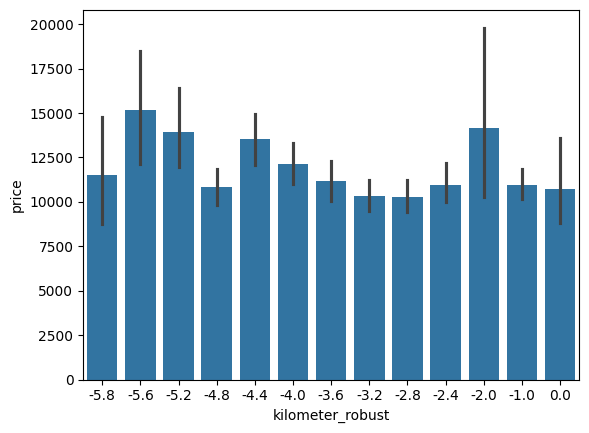

In [129]:
sns.barplot(df_filtrado, x="kilometer_robust", y="price")


Tenemos aproximadamente 7347 outliers, dado que no tenemos información sobre si se encuentran en la columna de kilometer o powerCV, reemplazaremos por la mediana en cada uno de los casos, dado que reducimos el impacto de eliminar datos, y evitamos la sensibilidad de la media a los valores extremos. No tenemos evidencias para eliminar los datos, recordemos, que aquellos datos que consideramos que podrian ser erroneos los eliminamos en el notebook de eda-nulos,  y siendo la distribución no normal, sustituiremos con este método.

In [130]:
df_filtrado["powerCV_robust"].mean()

np.float64(0.6111393147185171)

In [131]:
df_outliers.loc[df_filtrado.index, "kilometer_robust"] = df_filtrado["kilometer_robust"].mean()
df_outliers.loc[df_filtrado.index, "powerCV_robust"] = df_filtrado["powerCV_robust"].mean()
df_outliers.describe().T

,count,mean,std,min,25%,50%,75%,max
postalCode,371528.0,50820.667640,25799.082470,1067.00000,30459.000000,49610.000000,71546.000000,99998.0000
price,371528.0,5923.847881,12053.036525,1.00000,1250.000000,3000.000000,7300.000000,999999.0000
powerCV_robust,371528.0,0.177561,0.863441,-1.60371,-0.428487,0.041602,0.555762,13.0425
kilometer_robust,371528.0,-0.975252,1.583579,-5.80000,-2.000000,0.000000,0.000000,0.0000
outliers_lof_5_0.01,371528.0,0.980002,0.198990,-1.00000,1.000000,1.000000,1.000000,1.0000
outliers_lof_5_0.05,371528.0,0.955540,0.294861,-1.00000,1.000000,1.000000,1.000000,1.0000
outliers_lof_5_0.1,371528.0,0.955540,0.294861,-1.00000,1.000000,1.000000,1.000000,1.0000
outliers_lof_20_0.01,371528.0,0.980034,0.198831,-1.00000,1.000000,1.000000,1.000000,1.0000
outliers_lof_20_0.05,371528.0,0.900008,0.435875,-1.00000,1.000000,1.000000,1.000000,1.0000
outliers_lof_20_0.1,371528.0,0.896735,0.442569,-1.00000,1.000000,1.000000,1.000000,1.0000


In [132]:
# Completamos el dataframe con las variables categóricas con sus nulos ya tratados en el primer notebook.
df_categoricas = pd.read_csv("datos/categoricas.csv",index_col=0)
df_outliers_completo = pd.concat([df_outliers, df_categoricas], axis=1)

In [133]:
df_outliers_completo.head()

,postalCode,price,powerCV_robust,kilometer_robust,outliers_lof_5_0.01,outliers_lof_5_0.05,outliers_lof_5_0.1,outliers_lof_20_0.01,outliers_lof_20_0.05,outliers_lof_20_0.1,...,seller,offerType,abtest,vehicleType,yearOfRegistration,gearbox,monthOfRegistration,fuelType,brand,notRepairedDamage
0,70435,480.0,-0.374913,0.0,1,1,1,1,1,1,...,private,offer,test,desconocido,Clásico,manually,3.0,petrol,volkswagen,desconocido
1,66954,18300.0,1.128683,-1.0,1,1,1,1,1,1,...,private,offer,test,coupe,Moderno,manually,5.0,diesel,audi,yes
2,90480,9800.0,0.746735,-1.0,1,1,1,1,1,1,...,private,offer,test,suv,Moderno,automatic,8.0,diesel,jeep,desconocido
3,91074,1500.0,-0.531319,0.0,1,1,1,1,1,1,...,private,offer,test,small car,Moderno,manually,6.0,petrol,volkswagen,no
4,60437,3600.0,-0.619461,-2.4,1,1,1,1,1,1,...,private,offer,test,small car,Moderno,manually,7.0,diesel,skoda,no


In [134]:
df_outliers_completo.to_csv("datos/outliers_num.csv")